In [30]:
 import pandas as pd
 import numpy as np
 import xgboost as xgb
 import seaborn as sns
 import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
 from sklearn.metrics import classification_report
 from sklearn.metrics import confusion_matrix
 from sklearn.model_selection import train_test_split
 from sklearn.impute import SimpleImputer
 from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
 from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
 from sklearn.impute import SimpleImputer
 from sklearn.preprocessing import StandardScaler
 from imblearn.over_sampling import SMOTE
 import warnings
 warnings.filterwarnings("ignore")

In [31]:
#Loading Dataset
stroke_heart_data= pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_heart_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [32]:
print("Dataset Info:")
stroke_heart_data.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [33]:
stroke_heart_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [34]:
#check for NaN(missing values)
#The data has 201 missing value for BMI(Body Mass Index)
#deleting this 201 rows, will waste 3.93% of our data.It also reduces the model's training power
print("Nan counts:\n", stroke_heart_data.isna().sum())

Nan counts:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [35]:
#Improve missing value handliing
#-use median for BMI
#use the median to fill in the missing values found in the bmi
stroke_heart_data["bmi"].fillna(stroke_heart_data["bmi"].median(), inplace=True)

In [36]:
stroke_heart_clean = stroke_heart_data.copy()
stroke_heart_clean['bmi'] = stroke_heart_clean['bmi'].clip(upper=60)

In [37]:
# Check for obvious outliers
print("\nValue ranges:")
print(f"Age: {stroke_heart_data['age'].min()} - {stroke_heart_data['age'].max()}")
print(f"BMI: {stroke_heart_data['bmi'].min()} - {stroke_heart_data['bmi'].max()}")
print(f"Glucose: {stroke_heart_data['avg_glucose_level'].min()} - {stroke_heart_data['avg_glucose_level'].max()}")


Value ranges:
Age: 0.08 - 82.0
BMI: 10.3 - 97.6
Glucose: 55.12 - 271.74


In [38]:
#See if outliers were affecting stroke cases
print("\n=== OUTLIER ANALYSIS ===")
bmi_outliers = stroke_heart_data[stroke_heart_data['bmi'] > 60]
print(f"Patients with BMI > 60: {len(bmi_outliers)}")
print(f"Stroke cases in BMI outliers: {bmi_outliers['stroke'].sum()}")


=== OUTLIER ANALYSIS ===
Patients with BMI > 60: 13
Stroke cases in BMI outliers: 0


In [108]:
# Remove the outlier records (safe since they have no stroke cases)
stroke_heart_clean = stroke_heart_data[stroke_heart_data['bmi'] <= 60]
print(f"Removed {len(stroke_heart_data) - len(stroke_heart_clean)} records")

Removed 13 records


<function matplotlib.pyplot.show(close=None, block=None)>

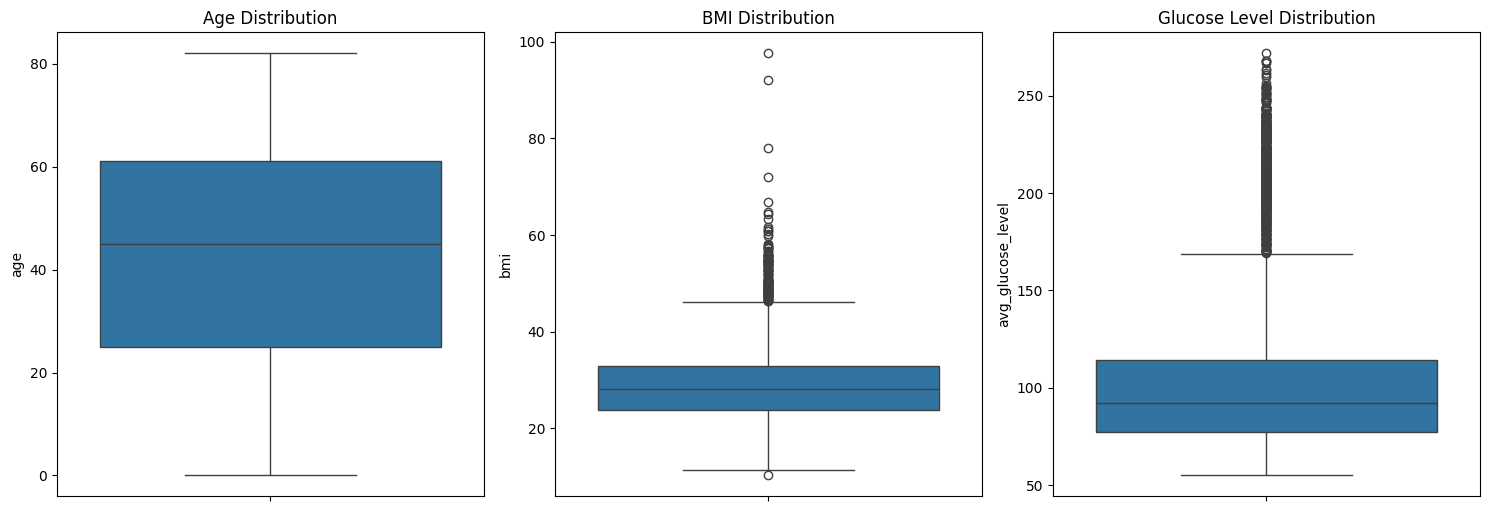

In [109]:
# Boxplots for numerical features
#visualizing outliers
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(y=stroke_heart_data['age'])
plt.title('Age Distribution')

plt.subplot(2, 3, 2)
sns.boxplot(y=stroke_heart_data['bmi'])
plt.title('BMI Distribution')

plt.subplot(2, 3, 3)
sns.boxplot(y=stroke_heart_data['avg_glucose_level'])
plt.title('Glucose Level Distribution')

plt.tight_layout()
plt.show

In [110]:
#stroke_heart_data_encoded = simple_categorical_encoding(stroke_heart_data)
categorical_cols = ['gender', 'ever_married','work_type','Residence_type','smoking_status']

In [111]:
def simple_categorical_encoding(stroke_heart_data):

    categorical_cols = ['gender', 'ever_married','work_type','Residence_type','smoking_status']
    stroke_heart_data_encoded = stroke_heart_data.copy() #a copy of the data to avoid modifying original

for col in categorical_cols:
    le = LabelEncoder()
    for col in categorical_cols:
        le = LabelEncoder()
        #stroke_heart_data_encoded = le.fit_transform(stroke_heart_data_encoded.astype(str))
       # stroke_heart_data_encoded[col] = le.fit_transform(stroke_heart_data_encoded[col].astype(str))
        
    

In [112]:
#X = stroke_heart_data_encoded.drop(['stroke', 'id'], axis=1)
#Y = stroke_heart_data_encoded['stroke']

X = stroke_heart_data.drop(['stroke', 'id'], axis=1)
Y = stroke_heart_data['stroke']
X = pd.get_dummies(X,drop_first=True, )  # Handle categorical vars

In [113]:
#Splitting of data , to avoid data leakage
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size= 0.2,random_state=42,stratify=Y)    
print (f"\nTraining set class distribution:\n{Y_train.value_counts()}")
print(f"Test set class distribution:\n{Y_test.value_counts()}")


Training set class distribution:
stroke
0    3889
1     199
Name: count, dtype: int64
Test set class distribution:
stroke
0    972
1     50
Name: count, dtype: int64


In [114]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [115]:
print(f"After scaling-Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

After scaling-Training: (4088, 16), Test: (1022, 16)


In [116]:
 #Calculate class weight for XGBoost
 #class weight is a technique to handle imbalanced datasets by making the model pay more attention to the minority class.
 scale_pos_weight = len(Y_train[Y_train==0])/len(Y_train[Y_train==1])
 print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Scale_pos_weight: 19.54


In [117]:
#Improved XGBoost Model with better parameters
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight,
eval_metric='logloss', max_depth=6,learning_rate=0.1, n_estimators=100, subsample=0.8,
reg_alpha=0.1, reg_lambda=0.1, use_label_encoder=False)

In [118]:
print("\nTraining XGBoost mode...")
#xgb_stroke_heart_data.fit(X_train_resampled, Y_train_resampled)
xgb_model.fit(X_train_scaled, Y_train)


Training XGBoost mode...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [119]:
#Cross-validation for better model evaluation
print("\nperforming cross-validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)       
#Cross-validation parameter
cv_scores = cross_val_score(xgb_model, X_train, Y_train, cv=cv, scoring ='roc_auc')
print(f"Cross-Validation ROC-AUC: {cv_scores.mean():.4f} (+- {cv_scores.std() * 2:.4f})")


performing cross-validation...
Cross-Validation ROC-AUC: 0.8070 (+- 0.0480)


In [120]:
#Make predictions
# Y_pred = xgb_stroke_heart_data.predict(X_test)
# Y_pred_proba = xgb_stroke_heart_data.predict_proba(X_test)[:,1]
Y_pred = xgb_model.predict(X_test_scaled)
Y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:,1]

In [121]:
 #Comprehensive Evaluation
print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(Y_test, Y_pred)
print(cm)


COMPREHENSIVE MODEL EVALUATION

=== CONFUSION MATRIX ===
[[921  51]
 [ 33  17]]



=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       972
           1       0.25      0.34      0.29        50

    accuracy                           0.92      1022
   macro avg       0.61      0.64      0.62      1022
weighted avg       0.93      0.92      0.92      1022


=== ROC-AUC SCORE ===
ROC-AUC: 0.8070


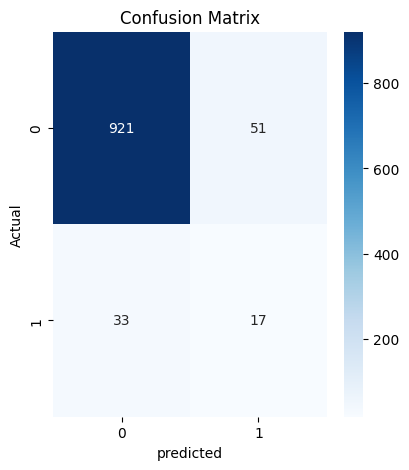

In [122]:
#Plot confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('predicted')
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(Y_test, Y_pred))
print(f"\n=== ROC-AUC SCORE ===")
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

In [123]:
#Threshold optimization for better recall
print("\n=== THRESHOLD OPTIMIZATION ===")
precision, recall, thresholds = precision_recall_curve(Y_test ,Y_pred_proba)


=== THRESHOLD OPTIMIZATION ===


In [124]:
#Threshold that gives at least 95% recall for stroke cases
target_recall=0.95
optimal_idx = np.argmax(recall >=target_recall)
optimal_threshold = thresholds[optimal_idx] if optimal_idx > 0 else 0.03  #using very low threshold to catch more strokes cases
print(f"optimal threshold for {target_recall:.0%} recall: {optimal_threshold:.5f}")

optimal threshold for 95% recall: 0.03000


In [125]:
#Making  predictions with optimized threshold
Y_pred_optimized = (Y_pred_proba >= optimal_threshold).astype(int)
print("\n===OPTIMIZED RESULTS (Better for Medical use) ===")
print(classification_report(Y_test, Y_pred_optimized))


===OPTIMIZED RESULTS (Better for Medical use) ===
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       972
           1       0.10      0.84      0.18        50

    accuracy                           0.63      1022
   macro avg       0.54      0.73      0.47      1022
weighted avg       0.94      0.63      0.73      1022



In [126]:
feature_names = X.columns
plt.figure(figsize = (14, 12))
feature_importance = xgb_model.feature_importances_ 
indices =np.argsort(feature_importance)[-10:] #Top 10 features

<Figure size 1400x1200 with 0 Axes>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'smoking_status_never smoked'),
  Text(1, 0, 'heart_disease'),
  Text(2, 0, 'gender_Male'),
  Text(3, 0, 'ever_married_Yes'),
  Text(4, 0, 'work_type_Self-employed'),
  Text(5, 0, 'avg_glucose_level'),
  Text(6, 0, 'hypertension'),
  Text(7, 0, 'bmi'),
  Text(8, 0, 'smoking_status_smokes'),
  Text(9, 0, 'age')])

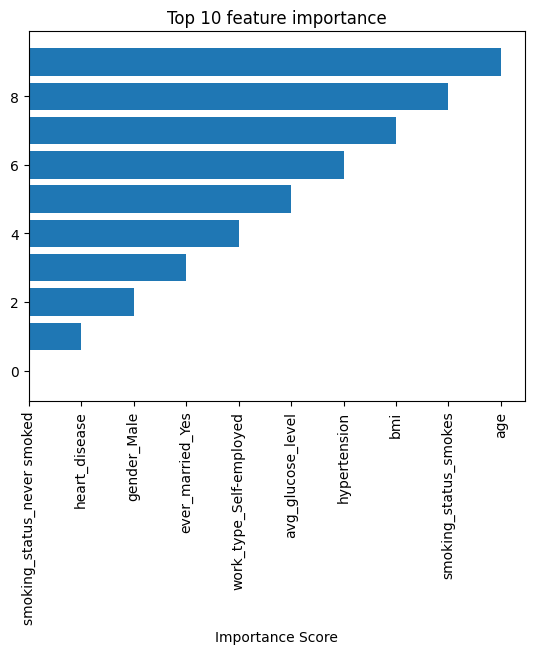

In [127]:
plt.barh(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 10 feature importance')
plt.xlabel('Importance Score')
plt.xticks(rotation =90) #help you to manage those value to avoid overlapping of value

In [128]:
 #Calculating the ROC-AOC score, which are essential for evaluating model performance,
 #fpr-false positive rate, tpr-true positive rate
fpr, tpr, thresholds =roc_curve(Y_test, Y_pred_proba)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)

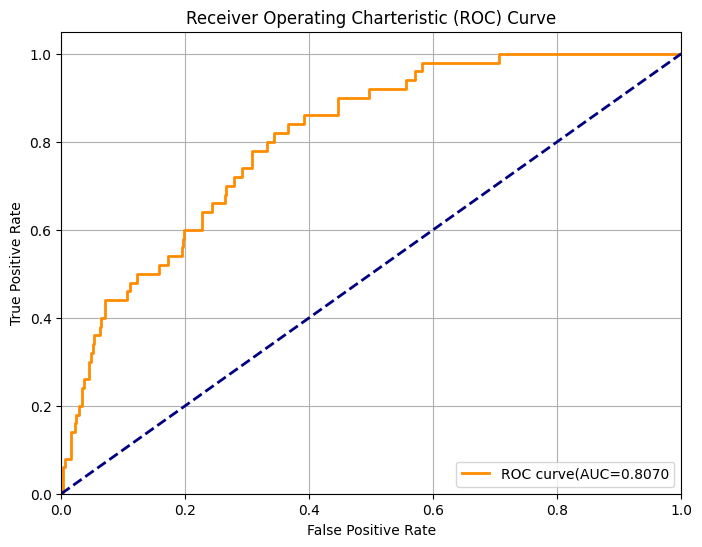

In [129]:
#ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(AUC={roc_auc:.4f}')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()